<a href="https://colab.research.google.com/github/RafaelCerq/EstudosPython/blob/main/GansRedesAdvers%C3%A1riasGenerativas/Gans_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN - Deep Convolutional GANs

## Importação das bibliotecas


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.9.2'

## Carregamento e pré-processamento da base de dados

- MNIST é o nome da base de dados que possui os digitos escritos a mão




In [2]:
(X_treinamento, y_treinamento), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
X_treinamento.shape


(60000, 28, 28)

In [4]:
28 * 28

784

In [5]:
y_treinamento.shape

(60000,)

1


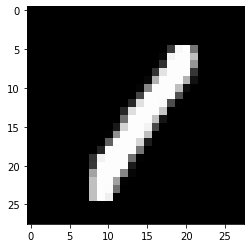

In [6]:
i = np.random.randint(0, 60000)
#print(i)
print(y_treinamento[i])
plt.imshow(X_treinamento[i], cmap = 'gray');

Incluindo número de canais ao final do vetor x_treinamento

In [7]:
X_treinamento = X_treinamento.reshape(X_treinamento.shape[0], 28, 28, 1).astype('float32')

In [8]:
X_treinamento.shape

(60000, 28, 28, 1)

In [9]:
X_treinamento[0].min(), X_treinamento[0].max()

(0.0, 255.0)

Aplicando normalização para treinamento da rede - Ao utilizar uma GAN é recomendado utilizar escalas entre -1 e 1. (127.5 é o valor que esta no meio de 255.0)

In [10]:
X_treinamento = (X_treinamento - 127.5) / 127.5

In [11]:
X_treinamento[0].min(), X_treinamento[0].max()

(-1.0, 1.0)

Dividir a base de dados de treinamento em batch. No caso, cada batch possui 256 imagens

In [12]:
buffer_size = 60000
batch_size = 256

In [13]:
buffer_size / batch_size

234.375

In [14]:
type(X_treinamento)

numpy.ndarray

Converte a base para o formato do tensorflow e dividir em batch

In [15]:
X_treinamento = tf.data.Dataset.from_tensor_slices(X_treinamento).shuffle(buffer_size).batch(batch_size)

In [16]:
type(X_treinamento)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [17]:
X_treinamento

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# Construção do gerador

- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
- Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/
- Funções de ativação: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e
- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

In [18]:
def cria_gerador():
  network = tf.keras.Sequential()

  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding='same', use_bias=False, strides=(2,2)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size=(5,5), padding='same',use_bias=False, strides=(2,2), activation = 'tanh'))

  network.summary()
  
  return network

In [19]:
gerador = cria_gerador()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [20]:
# 100 -> 12544
gerador.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_input')>

In [21]:
ruido = tf.random.normal([1, 100])
ruido

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-1.3408707 , -2.6738186 ,  0.01737233, -0.65473664, -1.2461883 ,
        -0.46230778,  0.1128033 ,  0.5864473 ,  1.2907217 ,  0.8064785 ,
         0.9166771 ,  0.07825478, -1.7989981 , -0.891943  , -0.78870255,
        -1.0578365 ,  0.3637721 ,  1.2883373 , -0.44760385, -0.19691744,
        -0.29853866, -1.4294081 , -0.63484323, -0.44121504, -0.45235243,
        -0.3275004 , -0.60712016,  2.3659642 ,  0.16121875, -1.4696009 ,
        -0.68027717,  0.38169163, -0.141735  ,  0.755304  , -0.440399  ,
        -0.24372582, -0.15598437,  0.06776179,  0.6549085 ,  0.58877957,
         0.3906684 ,  0.05994128,  0.5993318 ,  0.28871349, -0.3586965 ,
        -1.8687562 ,  0.87206155,  0.2000561 , -0.55598927, -1.6449589 ,
         0.68587446, -0.0487371 ,  0.04502459, -1.3014181 ,  1.0499758 ,
         0.7593839 , -0.32350886, -1.769209  , -0.7150416 ,  0.17268004,
        -0.52678144, -0.11040903,  1.9321922 ,  1.1509413 ,  0.53753734,
 

In [22]:
imagem_gerada = gerador(ruido, training = False)

In [23]:
imagem_gerada.shape

TensorShape([1, 28, 28, 1])

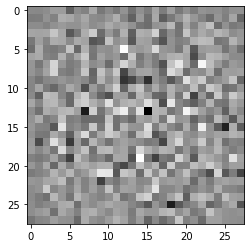

In [24]:
plt.imshow(imagem_gerada[0, :, :, 0], cmap='gray');

# Construção do discriminador

- Dropout: https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
- Conv2d x Conv2dTranspose: https://stackoverflow.com/questions/68976745/in-keras-what-is-the-difference-between-conv2dtranspose-and-conv2d

In [25]:
def cria_discriminador():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(filters = 64, strides=(2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(filters = 128, strides=(2,2), kernel_size = (5,5), padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network

In [2]:
7 * 7 * 128

6272

In [26]:
discriminador = cria_discriminador()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [27]:
discriminador.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

In [28]:
discriminador(imagem_gerada, training = False) # logits

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0010831]], dtype=float32)>

In [29]:
tf.sigmoid(0.00356018)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5008901>